In [1]:
import gc
import glob
import os

import pandas as pd
from tqdm.notebook import tqdm

tqdm.pandas()

import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
from rdkit import Chem, rdBase
from rdkit.Chem import AllChem, Descriptors, PandasTools
from rdkit.Chem.Draw import IPythonConsole

In [2]:
# /workdir/practical-mi-guide/chapter5/input/PubChem_compound_smarts_O=C(O).csvを読み込む
df = pd.read_csv("../input/PubChem_compound_smarts_O=C(O).csv")
df

,cid,cmpdname,cmpdsynonym,mw,mf,polararea,complexity,xlogp,heavycnt,hbonddonor,...,gpfamilycnt,neighbortype,meshheadings,annothits,annothitcnt,aids,cidcdate,sidsrcname,depcatg,annotation
0,4109,Methomyl,16752-77-5|Lannate|Mesomile|Methomyl|Methyl N-...,162.21,C5H10N2O2S,76.0,147.0,0.6,10,1,...,498,2D+3D,Methomyl,Agrochemical Information|Biological Test Resul...,16,425000|977599|977602|1081777|1081778|1081779|1...,20050325,3B Scientific (Wuhan) Corp|ABI Chem|Acadechem|...,Chemical Vendors|Curation Efforts|Governmental...,D004791 - Enzyme Inhibitors|D010575 - Pesticid...
1,6249,Ampicillin,69-53-4|Ampicillin|Aminobenzylpenicillin|Ampic...,349.40,C16H19N3O4S,138.0,562.0,-1.1,24,3,...,69138,2D+3D,Ampicillin,Biological Test Results|Chemical and Physical ...,16,357|361|364|368|371|373|374|375|411|422|425|42...,20050624,001Chemical|3B Scientific (Wuhan) Corp|3WAY PH...,Chemical Vendors|Curation Efforts|Governmental...,C254 - Anti-Infective Agent > C258 - Antibioti...
2,6277,Cobalt(II) acetate,Cobalt acetate|Cobalt(II) acetate|71-48-7|Coba...,177.02,C4H6CoO4,80.3,25.5,NaN,9,0,...,20991,2D,NaN,Biological Test Results|Chemical and Physical ...,14,651631|651632|651633|651634|720516|720552|7206...,20050719,3B Scientific (Wuhan) Corp|3WAY PHARM INC|ABI ...,Chemical Vendors|Curation Efforts|Governmental...,NaN
3,10112,Calcium Carbonate,Aragonite|CALCIUM CARBONATE|471-34-1|Limestone...,100.09,CCaO3,63.2,18.8,NaN,5,0,...,119575,2D,Calcium Carbonate,Agrochemical Information|Biological Test Resul...,16,1259407|1259409,20040916,001Chemical|3B Scientific (Wuhan) Corp|3WAY PH...,Chemical Vendors|Curation Efforts|Governmental...,A - Alimentary tract and metabolism > A02 - Dr...
4,36314,Paclitaxel,33069-62-4|P88XT4IS4D|Paclitaxel|Taxol|Taxol A...,853.90,C47H51NO14,221.0,1790.0,2.5,62,4,...,64277,2D,NaN,Biological Test Results|Chemical and Physical ...,15,1|3|5|7|9|11|13|15|17|19|21|23|25|27|29|31|33|...,20050326,001Chemical|3B Scientific (Wuhan) Corp|3WAY PH...,Chemical Vendors|Curation Efforts|Governmental...,C274 - Antineoplastic Agent > C186664 - Cytoto...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,60148448,Pharmakon1600-01503834,GADOTERIDOL|120066-54-8|Pharmakon1600-01503834...,559.70,C17H30GdN4O7+,134.0,494.0,NaN,29,1,...,0,2D,NaN,Biological Test Results|Chemical and Physical ...,13,1794731|1794732|1794733|1794735|1794736|179473...,20120831,DTP/NCI|ToxPlanet,Governmental Organizations|Legacy Depositors|S...,V - Various > V08 - Contrast media > V08C - Ma...
996,133562742,"(3S,5R,6R,7S,9S,12S,13S,14R)-6-[(2R,3S,4R,6S)-...",oleandomycin,687.90,C35H61NO12,166.0,1090.0,2.6,48,3,...,0,2D,Oleandomycin,Chemical and Physical Properties|Classificatio...,13,NaN,20180525,Ambinter|Wikidata,Chemical Vendors|Curation Efforts,D000890 - Anti-Infective Agents > D000900 - An...
997,134755071,"methyl (9R,10S,11S,12R,19R)-11-acetyloxy-12-et...",vincristine,825.00,C46H56N4O10,171.0,1750.0,2.8,60,3,...,0,2D,NaN,Biological Test Results|Chemical and Physical ...,13,1508598,20180905,Cheminformatics Friedrich-Schiller-University ...,Legacy Depositors|Research and Development,L - Antineoplastic and immunomodulating agents...
998,136601293,"[(7S,9Z,11S,12R,13S,14R,15R,16R,17S,18S,19Z,21...",rifampin|Rifampicin|CHEMBL1523493|PD087064,822.90,C43H58N4O12,220.0,1620.0,4.9,59,6,...,2,2D,Rifampin,Biological Test Results|Chemical and Physical ...,13,1671498,20190124,ChEMBL|Google Patents|Human Metabolome Databas...,Curation Efforts|Research and Development,D000890 - Anti-Infective Agents > D000900 - An...


In [3]:
# dfの列名を表示
df.columns

Index([' cid', 'cmpdname', 'cmpdsynonym', 'mw', 'mf', 'polararea',
       'complexity', 'xlogp', 'heavycnt', 'hbonddonor', 'hbondacc', 'rotbonds',
       'inchi', 'isosmiles', 'canonicalsmiles', 'inchikey', 'iupacname',
       'exactmass', 'monoisotopicmass', 'charge', 'covalentunitcnt',
       'isotopeatomcnt', 'totalatomstereocnt', 'definedatomstereocnt',
       'undefinedatomstereocnt', 'totalbondstereocnt', 'definedbondstereocnt',
       'undefinedbondstereocnt', 'pclidcnt', 'gpidcnt', 'gpfamilycnt',
       'neighbortype', 'meshheadings', 'annothits', 'annothitcnt', 'aids',
       'cidcdate', 'sidsrcname', 'depcatg', 'annotation'],
      dtype='object')

In [4]:
# dfの'canonicalsmiles'を表示
df["canonicalsmiles"]

0                                       CC(=NOC(=O)NC)SC
1      CC1(C(N2C(S1)C(C2=O)NC(=O)C(C3=CC=CC=C3)N)C(=O...
2                           CC(=O)[O-].CC(=O)[O-].[Co+2]
3                                 C(=O)([O-])[O-].[Ca+2]
4      CC1=C2C(C(=O)C3(C(CC4C(C3C(C(C2(C)C)(CC1OC(=O)...
                             ...                        
995    CC(CN1CCN(CCN(CCN(CC1)CC(=O)[O-])CC(=O)[O-])CC...
996    CC1CC(C(C(O1)OC2C(CC3(CO3)C(=O)C(C(C(C(OC(=O)C...
997    CCC1(CC2CC(C3=C(CCN(C2)C1)C4=CC=CC=C4N3)(C5=C(...
998    CC1C=CC=C(C(=O)NC2=C(C(=C3C(=C2O)C(=C(C4=C3C(=...
999    COC1=CC(=CC(=C1O)OC)C2C3C(COC3=O)C(C4=CC5=C(C=...
Name: canonicalsmiles, Length: 1000, dtype: object

In [5]:
# dfから'cmpdname'と'canonicalsmiles'のみを抽出
df = df[["cmpdname", "canonicalsmiles"]]
df

,cmpdname,canonicalsmiles
0,Methomyl,CC(=NOC(=O)NC)SC
1,Ampicillin,CC1(C(N2C(S1)C(C2=O)NC(=O)C(C3=CC=CC=C3)N)C(=O...
2,Cobalt(II) acetate,CC(=O)[O-].CC(=O)[O-].[Co+2]
3,Calcium Carbonate,C(=O)([O-])[O-].[Ca+2]
4,Paclitaxel,CC1=C2C(C(=O)C3(C(CC4C(C3C(C(C2(C)C)(CC1OC(=O)...
...,...,...
995,Pharmakon1600-01503834,CC(CN1CCN(CCN(CCN(CC1)CC(=O)[O-])CC(=O)[O-])CC...
996,"(3S,5R,6R,7S,9S,12S,13S,14R)-6-[(2R,3S,4R,6S)-...",CC1CC(C(C(O1)OC2C(CC3(CO3)C(=O)C(C(C(C(OC(=O)C...
997,"methyl (9R,10S,11S,12R,19R)-11-acetyloxy-12-et...",CCC1(CC2CC(C3=C(CCN(C2)C1)C4=CC=CC=C4N3)(C5=C(...
998,"[(7S,9Z,11S,12R,13S,14R,15R,16R,17S,18S,19Z,21...",CC1C=CC=C(C(=O)NC2=C(C(=C3C(=C2O)C(=C(C4=C3C(=...


,cmpdname,canonicalsmiles,ROMol
0,Methomyl,CC(=NOC(=O)NC)SC,
1,Ampicillin,CC1(C(N2C(S1)C(C2=O)NC(=O)C(C3=CC=CC=C3)N)C(=O...,
2,Cobalt(II) acetate,CC(=O)[O-].CC(=O)[O-].[Co+2],
3,Calcium Carbonate,C(=O)([O-])[O-].[Ca+2],
4,Paclitaxel,CC1=C2C(C(=O)C3(C(CC4C(C3C(C(C2(C)C)(CC1OC(=O)...,
...,...,...,...
995,Pharmakon1600-01503834,CC(CN1CCN(CCN(CCN(CC1)CC(=O)[O-])CC(=O)[O-])CC...,
996,"(3S,5R,6R,7S,9S,12S,13S,14R)-6-[(2R,3S,4R,6S)-...",CC1CC(C(C(O1)OC2C(CC3(CO3)C(=O)C(C(C(C(OC(=O)C...,
997,"methyl (9R,10S,11S,12R,19R)-11-acetyloxy-12-et...",CCC1(CC2CC(C3=C(CCN(C2)C1)C4=CC=CC=C4N3)(C5=C(...,
998,"[(7S,9Z,11S,12R,13S,14R,15R,16R,17S,18S,19Z,21...",CC1C=CC=C(C(=O)NC2=C(C(=C3C(=C2O)C(=C(C4=C3C(=...,

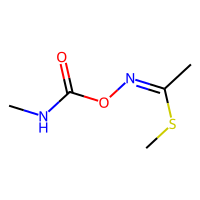
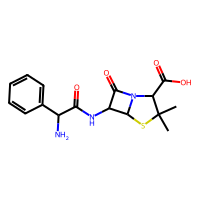
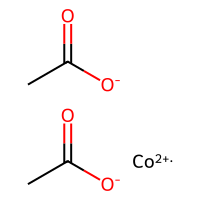
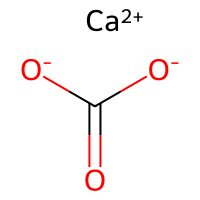
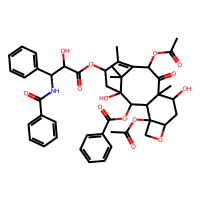
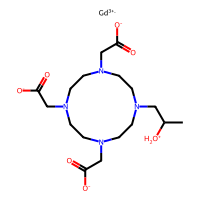
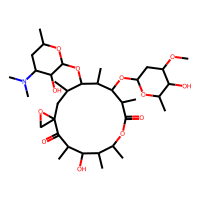
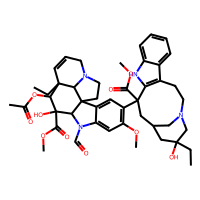
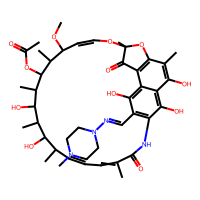
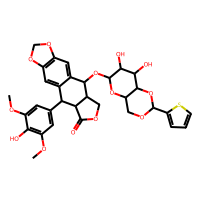

In [6]:
# molオブジェクトを作成
PandasTools.AddMoleculeColumnToFrame(df, "canonicalsmiles")
display(df)

,cmpdname,canonicalsmiles,ROMol,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,Methomyl,CC(=NOC(=O)NC)SC,,10.382504,-0.547778,10.382504,0.547778,0.271082,162.214,152.134,...,1,0,0,0,0,0,0,0,0,0
1,Ampicillin,CC1(C(N2C(S1)C(C2=O)NC(=O)C(C3=CC=CC=C3)N)C(=O...,,12.334173,-1.033228,12.334173,0.374515,0.674878,349.412,330.260,...,1,0,0,0,0,0,0,0,0,0
2,Cobalt(II) acetate,CC(=O)[O-].CC(=O)[O-].[Co+2],,8.888889,-1.083333,8.888889,0.000000,0.409563,177.021,170.973,...,0,0,0,0,0,0,0,0,0,0
3,Calcium Carbonate,C(=O)([O-])[O-].[Ca+2],,8.333333,-2.333333,8.333333,0.000000,0.308163,100.086,100.086,...,0,0,0,0,0,0,0,0,0,0
4,Paclitaxel,CC1=C2C(C(=O)C3(C(CC4C(C3C(C(C2(C)C)(CC1OC(=O)...,,15.483795,-2.390958,15.483795,0.002885,0.129786,853.918,802.510,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,Pharmakon1600-01503834,CC(CN1CCN(CCN(CCN(CC1)CC(=O)[O-])CC(=O)[O-])CC...,,11.024428,-1.249440,11.024428,0.000000,0.262120,559.698,529.458,...,0,0,0,0,0,0,0,0,0,0
996,"(3S,5R,6R,7S,9S,12S,13S,14R)-6-[(2R,3S,4R,6S)-...",CC1CC(C(C(O1)OC2C(CC3(CO3)C(=O)C(C(C(C(OC(=O)C...,,13.881184,-1.095135,13.881184,0.198241,0.274195,687.868,626.380,...,0,0,0,0,0,0,0,0,0,0
997,"methyl (9R,10S,11S,12R,19R)-11-acetyloxy-12-et...",CCC1(CC2CC(C3=C(CCN(C2)C1)C4=CC=CC=C4N3)(C5=C(...,,15.321994,-2.531098,15.321994,0.155289,0.131025,824.972,768.524,...,0,0,0,0,0,0,0,0,0,0
998,"[(7S,9Z,11S,12R,13S,14R,15R,16R,17S,18S,19Z,21...",CC1C=CC=C(C(=O)NC2=C(C(=C3C(=C2O)C(=C(C4=C3C(=...,,14.425630,-2.042566,14.425630,0.055940,0.109485,822.953,764.489,...,0,0,0,0,0,0,0,0,0,0

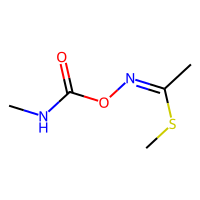
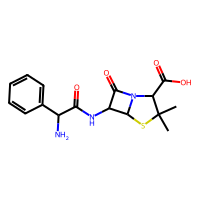
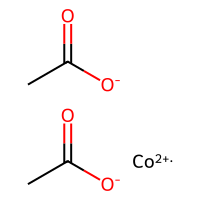
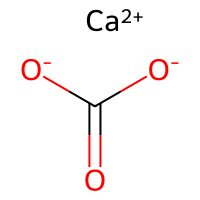
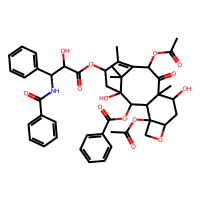
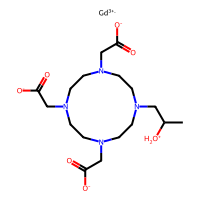
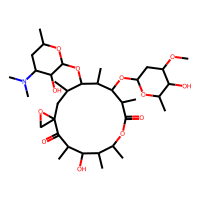
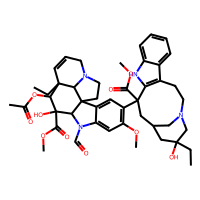
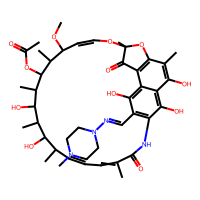
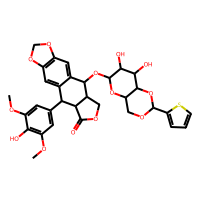

In [7]:
# RDKit記述子を計算
for i, j in Descriptors.descList:
    df[i] = df.ROMol.map(j)

df

In [8]:
# descListの中身をリストで表示
Descriptors.descList

[('MaxEStateIndex',
  <function rdkit.Chem.EState.EState.MaxEStateIndex(mol, force=1)>),
 ('MinEStateIndex',
  <function rdkit.Chem.EState.EState.MinEStateIndex(mol, force=1)>),
 ('MaxAbsEStateIndex',
  <function rdkit.Chem.EState.EState.MaxAbsEStateIndex(mol, force=1)>),
 ('MinAbsEStateIndex',
  <function rdkit.Chem.EState.EState.MinAbsEStateIndex(mol, force=1)>),
 ('qed',
  <function rdkit.Chem.QED.qed(mol, w=QEDproperties(MW=0.66, ALOGP=0.46, HBA=0.05, HBD=0.61, PSA=0.06, ROTB=0.65, AROM=0.48, ALERTS=0.95), qedProperties=None)>),
 ('MolWt', <function rdkit.Chem.Descriptors.<lambda>(*x, **y)>),
 ('HeavyAtomMolWt', <function rdkit.Chem.Descriptors.HeavyAtomMolWt(x)>),
 ('ExactMolWt', <function rdkit.Chem.Descriptors.<lambda>(*x, **y)>),
 ('NumValenceElectrons',
  <function rdkit.Chem.Descriptors.NumValenceElectrons(mol)>),
 ('NumRadicalElectrons',
  <function rdkit.Chem.Descriptors.NumRadicalElectrons(mol)>),
 ('MaxPartialCharge',
  <function rdkit.Chem.Descriptors.MaxPartialCharge(mo

In [9]:
len(Descriptors.descList)

208